In [1]:
# %pip install tqdm
# %pip install python-dotenv
# %pip install torch==2.4.0+cu118
# %pip install scikit_learn==1.2.2
# %pip install ipython
# %pip install pandas
# %pip install numpy
# %pip install matplotlib
# %pip install tabulate
# %pip install scipy
# %pip install git+https://github.com/Louis-Li-dev/ML_tool_kit

In [1]:
import os
import sys
parent_dir = os.path.join(os.getcwd(), '..')
if parent_dir not in sys.path: sys.path.append(parent_dir)
from utility.data_utils import *
from utility.visuals import *
from dotenv import load_dotenv
from model.CNN import ConditionalSegmentationVAE
from mkit.torch_support.tensor_utils import xy_to_tensordataset
from torch import nn
from IPython.display import clear_output
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from mkit.torch_support.tensor_utils import xy_to_tensordataset
from sklearn.decomposition import PCA
load_dotenv()
DATA_DIR = os.getenv("DATA_DIR")

- Dataset

In [2]:
if not os.path.exists(DATA_DIR): raise FileNotFoundError("Make sure the data directory is correctly placed.")

In [3]:
files = get_files(DATA_DIR)

return_list = []
file = files[0]
city_name = file.split('\\')[-1].split('.csv')[0].split('_')[0]

path_name = process_and_transform_data(file, resolution=.5, overwrite=True)
with open(path_name, 'rb') as f:
    result_dict = pickle.load(f)
labels = result_dict['labels']
encoder = result_dict['encoder']
MAX_LEN = result_dict['max length']
file_name = result_dict['file name']
WIDTH = result_dict['width']
HEIGHT = result_dict['height']

original dataset size: 238
dataset size with duplicates removed: 172


In [5]:
# for idx, label in enumerate(labels):
#     plt.imshow(labels[idx])
#     plt.savefig(f'../fig/{idx}_{file_name}.png')
#     plt.show()


- x y splitting

In [6]:



unique_labels = [u for u in labels if np.array(np.where(u != 0)).T.shape[0] > 1]
padded_labels = []
for label in unique_labels:
    unique_vals = np.unique(label)[1:]

    max_val = label.max()
    new_vals = []
    count = 0
    for val in unique_vals:    
        dummy_vals = np.zeros(label.shape)
        dummy_vals[np.where(label == val)] = 1
        new_vals.append(dummy_vals)
        count += 1
    for i in range(count, MAX_LEN):
        dummy_vals = np.zeros(label.shape)
        new_vals.append(dummy_vals)
    new_vals = np.array(new_vals)
    padded_labels.append(new_vals)
train_labels, test_labels = train_test_split(np.expand_dims(np.array(unique_labels), axis=1), test_size=.2)


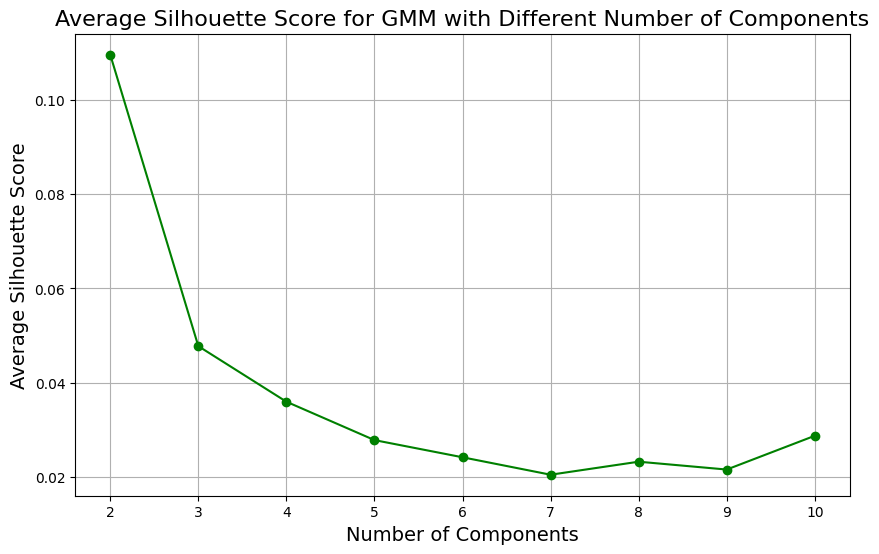

Optimal number of components based on Silhouette Score: 2


In [7]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import numpy as np

# Assuming 'train_labels' is the data you're transforming
pca = PCA(n_components=0.96)  # Retain 96% of variance for PCA
pca.fit(train_labels.reshape(train_labels.shape[0], -1))
transformed = pca.transform(train_labels.reshape(train_labels.shape[0], -1))

# Initialize list to store Silhouette Scores
silhouette_scores = []

# Fit GMM models for a range of components (1 to 10)
n_runs = 100  # Number of times to run the algorithm
for n_components in range(2, 11):  # Silhouette score requires at least 2 clusters
    avg_silhouette = 0
    for _ in range(n_runs):
        gmm = GaussianMixture(n_components=n_components, warm_start=True, init_params='k-means++')
        gmm.fit(transformed)
        
        # Predict the cluster labels
        transformed_labels = gmm.predict(transformed)
        
        # Calculate the silhouette score
        silhouette_avg = silhouette_score(transformed, transformed_labels)
        avg_silhouette += silhouette_avg
    
    # Average the silhouette scores from multiple runs
    avg_silhouette /= n_runs
    silhouette_scores.append(avg_silhouette)

# Plot the Silhouette Scores to visualize the optimal number of components
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', color='green')
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Average Silhouette Score', fontsize=14)
plt.title('Average Silhouette Score for GMM with Different Number of Components', fontsize=16)
plt.grid(True)
plt.show()

# Find the optimal number of components based on the highest Silhouette Score
best_silhouette_components = np.argmax(silhouette_scores) + 2  # Adding 2 because range starts at 2
print(f"Optimal number of components based on Silhouette Score: {best_silhouette_components}")

# You can now fit the GMM model with the optimal number of components:
optimal_gmm = GaussianMixture(n_components=best_silhouette_components, warm_start=True, init_params='k-means++')
optimal_gmm.fit(transformed)

# Get the cluster labels
transformed_labels = optimal_gmm.predict(transformed)


In [8]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_jobs=-1)
knn.fit(transformed)
features = []
for ele in transformed:
    indices = knn.kneighbors(ele.reshape(1, -1), n_neighbors=3, return_distance=False)[0]
    features.append(transformed[indices])
features = np.array(features)
features = features.reshape(features.shape[0], -1)

In [9]:
import torch
import torch.nn as nn

# Generator: Takes noise and condition vectors, outputs (batch_size, 1, width, height) image
class Generator(nn.Module):
    def __init__(self, noise_dim, condition_dim, width, height, base_feature_dim=64):
        """
        noise_dim: Dimension of the noise vector
        condition_dim: Dimension of the condition vector
        width, height: Target dimensions of the generated image (must be divisible by 4)
        base_feature_dim: Base number of features for the network
        """
        super(Generator, self).__init__()
        self.width = width
        self.height = height
        
        # The input dimension is the concatenation of noise and condition
        input_dim = noise_dim + condition_dim
        
        # Fully connected layer projects the input vector to an initial feature map.
        # We choose the initial spatial dimensions to be width//4 and height//4.
        self.fc = nn.Sequential(
            nn.Linear(input_dim, base_feature_dim * 2 * (width // 4) * (height // 4)),
            nn.BatchNorm1d(base_feature_dim * 2 * (width // 4) * (height // 4)),
            nn.LeakyReLU(.2)
        )
        
        # Deconvolution layers to upscale the feature map to the target image size.
        self.deconv = nn.Sequential(
            # Upsample from (width//4, height//4) -> (width//2, height//2)
            nn.ConvTranspose2d(base_feature_dim * 2, base_feature_dim, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(base_feature_dim),
            nn.LeakyReLU(.2),
            # Upsample from (width//2, height//2) -> (width, height)
            nn.ConvTranspose2d(base_feature_dim, 1, kernel_size=4, stride=2, padding=1),
            
        )
        
    def forward(self, noise, condition):
        # noise: (batch_size, noise_dim)
        # condition: (batch_size, condition_dim)
        # Concatenate noise and condition vectors
        x = torch.cat((noise, condition), dim=1)
        x = self.fc(x)
        # Reshape to a 4D tensor for convolution: (batch_size, channels, width//4, height//4)
        x = x.view(x.size(0), -1, self.width // 4, self.height // 4)
        x = self.deconv(x)
        return x

# Discriminator: Takes an image and condition vector, outputs a probability of being real.
class Discriminator(nn.Module):
    def __init__(self, condition_dim, width, height, base_feature_dim=64):
        """
        condition_dim: Dimension of the condition vector
        width, height: Dimensions of the input image (must be divisible by 4)
        base_feature_dim: Base number of features for the network
        """
        super(Discriminator, self).__init__()
        # Convolutional layers to extract features from the image
        self.conv = nn.Sequential(
            # Input image: (batch_size, 1, width, height)
            nn.Conv2d(1, base_feature_dim, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(base_feature_dim, base_feature_dim * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(base_feature_dim * 2),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # After conv layers, the feature map is of size (base_feature_dim * 2, width//4, height//4)
        # Flatten and concatenate the condition vector before the final classification layer.
        self.fc = nn.Sequential(
            nn.Linear(base_feature_dim * 2 * (width // 4) * (height // 4) + condition_dim, 1),
            nn.Sigmoid()  # Outputs a probability indicating real/fake
        )
        
    def forward(self, image, condition):
        # image: (batch_size, 1, width, height)
        # condition: (batch_size, condition_dim)
        x = self.conv(image)
        x = x.view(x.size(0), -1)
        # Concatenate condition information
        x = torch.cat((x, condition), dim=1)
        validity = self.fc(x)
        return validity



In [10]:
import torch
import torch.nn as nn
import torch.optim as optim

# Hyperparameters
noise_dim = 100
condition_dim = features.shape[-1]
batch_size = 32
width, height = WIDTH, HEIGHT
num_epochs = 7000
lr = 0.0002  # Learning rate
betas = (0.5, 0.999)  # Beta parameters for Adam optimizer

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the dataloader (assumes xy_to_tensordataset returns (condition, image) pairs)
loader = xy_to_tensordataset(features, train_labels, return_loader=True, batch_size=batch_size)

# Instantiate the generator and discriminator
G = Generator(noise_dim, condition_dim, width, height).to(device)
D = Discriminator(condition_dim, width, height).to(device)

# Loss function and optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adamax(G.parameters(), lr=lr, betas=betas)
optimizer_D = optim.Adamax(D.parameters(), lr=lr, betas=betas)

for epoch in range(num_epochs):
    avg_d_loss = 0.0
    avg_g_loss = 0.0

    for i, (conditions, real_images) in enumerate(loader):
        # Move real images and condition vectors to device
        real_images = real_images.to(device).float()
        conditions = conditions.to(device).float()
        current_batch_size = real_images.size(0)
        
        # Create ground-truth labels
        valid = torch.ones(current_batch_size, 1, device=device)  # Label 1 for real images
        fake = torch.zeros(current_batch_size, 1, device=device)  # Label 0 for fake images

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Generate fake images with noise and the same conditions
        noise = torch.randn(current_batch_size, noise_dim, device=device)
        fake_images = G(noise, conditions)

        # Loss for real images
        real_loss = criterion(D(real_images, conditions), valid)
        # Loss for fake images (detach to avoid backprop into generator)
        fake_loss = criterion(D(fake_images.detach(), conditions), fake)
        d_loss = (real_loss + fake_loss) / 2

        # Backprop and update discriminator
        d_loss.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        # Generate fake images (again) to compute generator loss
        noise = torch.randn(current_batch_size, noise_dim, device=device)
        fake_images = G(noise, conditions)
        # Generator loss: aim to fool the discriminator (labels are valid)
        g_loss = criterion(D(fake_images, conditions), valid)

        # Backprop and update generator
        g_loss.backward()
        optimizer_G.step()
        avg_g_loss += g_loss.item() / len(loader)
        avg_d_loss += d_loss.item() / len(loader)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss D: {avg_d_loss:.4f} | Loss G: {avg_g_loss:.4f}")


Epoch [1/7000] | Loss D: 0.2641 | Loss G: 2.3345
Epoch [2/7000] | Loss D: 0.0418 | Loss G: 3.4566
Epoch [3/7000] | Loss D: 0.0239 | Loss G: 3.8997
Epoch [4/7000] | Loss D: 0.0174 | Loss G: 4.2409
Epoch [5/7000] | Loss D: 0.0129 | Loss G: 4.4302
Epoch [6/7000] | Loss D: 0.0115 | Loss G: 4.6478
Epoch [7/7000] | Loss D: 0.0098 | Loss G: 4.6579
Epoch [8/7000] | Loss D: 0.0092 | Loss G: 4.7180
Epoch [9/7000] | Loss D: 0.0089 | Loss G: 4.7093
Epoch [10/7000] | Loss D: 0.0086 | Loss G: 4.6554
Epoch [11/7000] | Loss D: 0.0082 | Loss G: 4.7338
Epoch [12/7000] | Loss D: 0.0076 | Loss G: 4.7947
Epoch [13/7000] | Loss D: 0.0066 | Loss G: 4.9978
Epoch [14/7000] | Loss D: 0.0056 | Loss G: 5.1785
Epoch [15/7000] | Loss D: 0.0048 | Loss G: 5.4029
Epoch [16/7000] | Loss D: 0.0042 | Loss G: 5.5522
Epoch [17/7000] | Loss D: 0.0040 | Loss G: 5.6862
Epoch [18/7000] | Loss D: 0.0036 | Loss G: 5.7981
Epoch [19/7000] | Loss D: 0.0032 | Loss G: 5.8686
Epoch [20/7000] | Loss D: 0.0030 | Loss G: 5.8986
Epoch [21

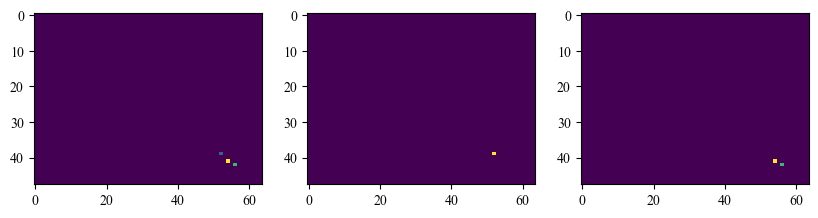

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes = axes.flatten()
axes[0].imshow(test_labels[0][0])
x, y, _, _ = get_x_y(test_labels, MAX_LEN=MAX_LEN, encoder=encoder)
x = np.array(x)
y = np.array(y)
axes[1].imshow(x[0][0])
axes[2].imshow(y[0][0])
plt.show()

In [18]:

# Assuming 'train_labels' is the data you're transforming
test_pca = PCA(n_components=0.96)  # Retain 96% of variance for PCA
test_pca.fit(x.reshape(x.shape[0], -1))
test_transformed = pca.transform(x.reshape(x.shape[0], -1))
test_transformed.shape, x.shape


((34, 28), (34, 1, 48, 64))

In [19]:

test_features = []
for ele in test_transformed:
    indices = knn.kneighbors(ele.reshape(1, -1), n_neighbors=3, return_distance=False)[0]
    test_features.append(transformed[indices])
test_features = np.array(test_features)
test_features = test_features.reshape(test_features.shape[0], -1)
test_features.shape

(34, 84)

In [20]:
x.shape, y.shape

((34, 1, 48, 64), (34, 1, 48, 64))

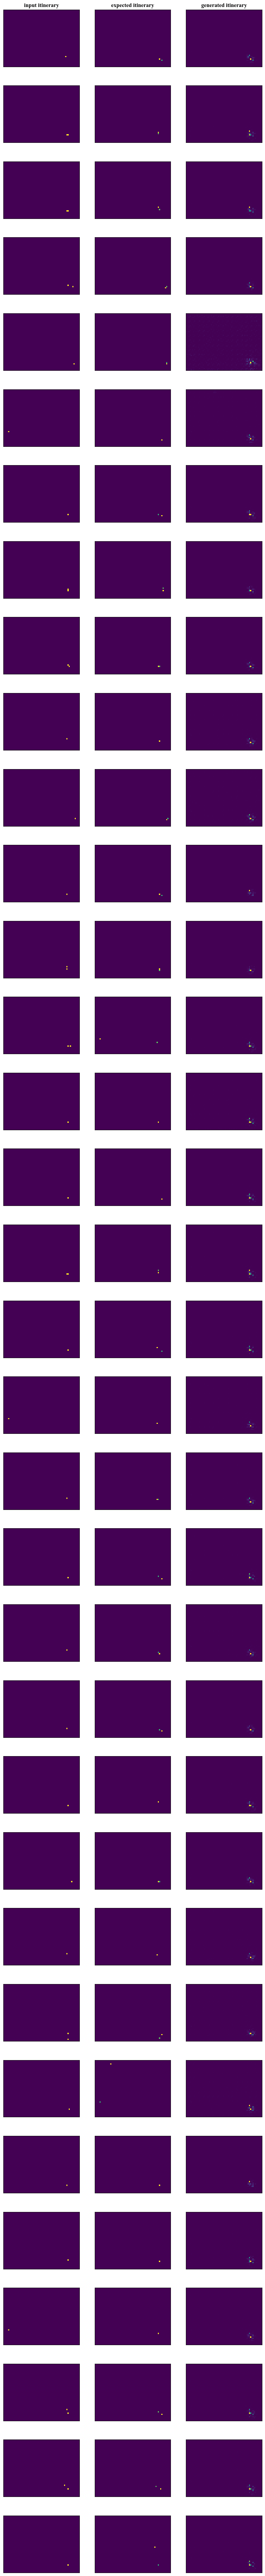

In [21]:
test_input = torch.tensor(test_features).float().to(device)
index = 18
noise = torch.randn(test_input.shape[0], noise_dim, device=device)
output = G(noise, test_input)[:, 0, :, :].detach().cpu().numpy()
output[output < 0] = 0
attempt = 1
plt.rcParams['font.family'] = 'Times New Roman'
fig, axes_list = plt.subplots(len(output), 3, figsize=(10, 100))
for i in range(len(output)):
    axes = axes_list[i].flatten()

    axes[0].imshow(x[i][0])
    axes[1].imshow(y[i][0])
    axes[2].imshow(output[i])
    if i == 0:
        axes[0].set_title('input itinerary', fontweight='bold')
        axes[1].set_title('expected itinerary', fontweight='bold')
        axes[2].set_title('generated itinerary', fontweight='bold')
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])

plt.savefig(f'../fig/gan_output/{i}_{attempt}.png')


In [16]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torch.utils.data as data
# from torch.autograd import Variable

# # Define the Generator Network
# class Generator(nn.Module):
#     def __init__(self, condition_size, latent_dim):
#         super(Generator, self).__init__()
        
#         # Condition input is combined with the latent vector
#         self.fc1 = nn.Linear(latent_dim + condition_size, 256)
#         self.fc2 = nn.Linear(256, 512)
#         self.fc3 = nn.Linear(512, 1024)
#         self.fc4 = nn.Linear(1024, 1 * 48 * 64)  # Output size (132, 1, 48, 64)
        
#         self.relu = nn.ReLU()
#         self.tanh = nn.Tanh()

#     def forward(self, z, condition):
#         # Concatenate condition with random noise z
#         x = torch.cat([z, condition], dim=1)
#         x = self.relu(self.fc1(x))
#         x = self.relu(self.fc2(x))
#         x = self.relu(self.fc3(x))
#         x = self.fc4(x)
        
#         # Reshape to the image dimensions (batch_size, 1, 48, 64)
#         return self.tanh(x).view(-1, 1, 48, 64)

# # Define the Discriminator Network
# class Discriminator(nn.Module):
#     def __init__(self, condition_size):
#         super(Discriminator, self).__init__()

#         self.fc1 = nn.Linear(1 * 48 * 64 + condition_size, 1024)
#         self.fc2 = nn.Linear(1024, 512)
#         self.fc3 = nn.Linear(512, 256)
#         self.fc4 = nn.Linear(256, 1)  # Output real or fake

#         self.leaky_relu = nn.LeakyReLU(0.2)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, image, condition):
#         # Flatten the image and concatenate with condition
#         x = image.view(image.size(0), -1)  # Flatten image (batch_size, 1*48*64)
#         x = torch.cat([x, condition], dim=1)  # Concatenate with condition
#         x = self.leaky_relu(self.fc1(x))
#         x = self.leaky_relu(self.fc2(x))
#         x = self.leaky_relu(self.fc3(x))
#         x = self.fc4(x)
        
#         return self.sigmoid(x)  # Probability of being real

# # Initialize the generator and discriminator
# latent_dim = 100  # Size of the random noise vector
# condition_size = 27  # Size of the condition vector

# generator = Generator(condition_size, latent_dim)
# discriminator = Discriminator(condition_size)

# # Optimizers
# lr = 0.0002  # Learning rate
# b1 = 0.5  # Beta1 for Adam optimizer
# b2 = 0.999  # Beta2 for Adam optimizer

# optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
# optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

# # Loss function
# adversarial_loss = nn.BCELoss()

# # Training loop (skeleton)
# epochs = 10000  # Number of training epochs
# for epoch in range(epochs):
#     # Generate random noise and fake images
#     z = torch.randn(132, latent_dim)  # Latent space
#     condition = torch.randn(132, condition_size)  # Condition vector

#     # Generate fake images
#     fake_images = generator(z, condition)

#     # Train Discriminator: Maximize log(D(x)) + log(1 - D(G(z)))
#     optimizer_D.zero_grad()
    
#     real_images = torch.randn(132, 1, 48, 64)  # Placeholder for real images (replace with actual data)

#     real_labels = torch.ones(132, 1)  # Real labels (1)
#     fake_labels = torch.zeros(132, 1)  # Fake labels (0)

#     # Compute discriminator loss for real and fake
#     real_loss = adversarial_loss(discriminator(real_images, condition), real_labels)
#     fake_loss = adversarial_loss(discriminator(fake_images.detach(), condition), fake_labels)
#     d_loss = (real_loss + fake_loss) / 2
#     d_loss.backward()
#     optimizer_D.step()

#     # Train Generator: Maximize log(D(G(z)))
#     optimizer_G.zero_grad()
#     g_loss = adversarial_loss(discriminator(fake_images, condition), real_labels)
#     g_loss.backward()
#     optimizer_G.step()

#     if epoch % 1000 == 0:
#         print(f"Epoch [{epoch}/{epochs}] | D Loss: {d_loss.item()} | G Loss: {g_loss.item()}")
raise Exception

Exception: 

In [ ]:

# Assuming 'train_labels' is the data you're transforming
pca = PCA(n_components=2)  # Use two components for visualization
pca.fit(train_labels.reshape(train_labels.shape[0], -1))
transformed = pca.transform(train_labels.reshape(train_labels.shape[0], -1))

# Apply Gaussian Mixture Model (GMM) clustering
gmm = GaussianMixture(n_components=2, warm_start=True, init_params='k-means++')  # Set number of clusters (you can adjust this based on your data)
gmm.fit(transformed)
transformed_labels = gmm.predict(transformed)  # Get the cluster labels

# Plot the transformed data with the GMM labels
plt.figure(figsize=(8, 6))

# Plot the points, color-coded by cluster label
scatter = plt.scatter(transformed[:, 0], transformed[:, 1], c=transformed_labels, cmap='viridis', alpha=0.7, edgecolors='k', s=50)

# Optionally, plot the ellipses representing the covariance of each cluster
ax = plt.gca()
for i in range(gmm.n_components):
    mean = gmm.means_[i]
    cov = gmm.covariances_[i]
    v, w = np.linalg.eigh(cov)  # Eigenvalues and eigenvectors of the covariance matrix
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)  # Scale by 2 standard deviations
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])  # Compute the angle of the ellipse
    angle = 180.0 * angle / np.pi  # Convert to degrees
    
    # Plot the ellipse
    ell = plt.matplotlib.patches.Ellipse(mean, v[0], v[1], angle=angle, color='gray', alpha=0.3)
    ax.add_patch(ell)

# Add a color bar to show cluster labels
plt.colorbar(scatter, label='Cluster Label')

plt.title("PCA + Gaussian Mixture Model Clustering (First Two Components)", fontsize=16)
plt.xlabel("Principal Component 1", fontsize=14)
plt.ylabel("Principal Component 2", fontsize=14)
plt.grid(True)
plt.show()


In [ ]:

# Assuming 'train_labels' is the data you're transforming
pca = PCA(n_components=2)  # We use two components for visualization
pca.fit(train_labels.reshape(train_labels.shape[0], -1))
transformed = pca.transform(train_labels.reshape(train_labels.shape[0], -1))

# Apply DBSCAN clustering
db = DBSCAN(eps=.6)
db.fit(transformed)
transformed_labels = db.labels_  # The cluster labels for each point

# Plot the transformed data with the DBSCAN labels
plt.figure(figsize=(8, 6))

# Plot the points, color-coded by cluster
scatter = plt.scatter(transformed[:, 0], transformed[:, 1], c=transformed_labels, cmap='viridis', alpha=0.7, edgecolors='k', s=50)

# Add a color bar to show cluster labels
plt.colorbar(scatter, label='Cluster Label')

plt.title("PCA + DBSCAN Clustering (First Two Components)", fontsize=16)
plt.xlabel("Principal Component 1", fontsize=14)
plt.ylabel("Principal Component 2", fontsize=14)
plt.grid(True)
plt.show()


In [ ]:


# Assuming 'train_labels' is the data you're transforming
pca = PCA(n_components=2)  # Only the first two components for visualization
pca.fit(train_labels.reshape(train_labels.shape[0], -1))
transformed = pca.transform(train_labels.reshape(train_labels.shape[0], -1))

# Plot the transformed data
plt.figure(figsize=(8, 6))
plt.scatter(transformed[:, 0], transformed[:, 1], alpha=0.7, edgecolors='k', s=50)
plt.title("PCA of Dimensionally Reduced Itineraries", fontsize=16)
plt.xlabel("Principal Component 1", fontsize=14)
plt.ylabel("Principal Component 2", fontsize=14)
plt.grid(True)
plt.show()


In [ ]:
pca = PCA(n_components=.98)
pca.fit(train_labels.reshape(train_labels.shape[0], -1))
transformed = pca.transform(train_labels.reshape(train_labels.shape[0], -1))
plt.imshow(train_labels[0][0])
print(transformed.shape)
plt.show()
sample = pca.inverse_transform(transformed).reshape(train_labels.shape)[0][0]
plt.imshow(sample)    
plt.show()

- data processing

In [ ]:

loader, val_loader = xy_to_tensordataset(
    train_labels, train_labels,
    return_loader=True, 
    batch_size=32,
    input_dtype=torch.float32,
    output_dtype=torch.float32,
    val_ratio=.15,
)

In [ ]:
next(iter(loader))[0].shape

In [ ]:
from mkit.torch_support.nn_utils import training_loop
model = AE(basic_dim=64, n_layers=2)

training_loop(
    model, 
    train_loader=loader,
    val_loader=val_loader,
    optimizer=torch.optim.Adamax(model.parameters()),
    criterion=nn.L1Loss(),
    device=torch.device('cuda'),
    epochs=1000,
    early_stopping=True,
    patience=15
)

In [ ]:
pred = model(torch.tensor(test_labels, dtype=torch.float32, device=torch.device('cuda')))


In [ ]:
import os
import matplotlib.pyplot as plt
for idx in range(len(test_labels)):
    for count, (pred_img, label_img) in enumerate(zip(pred[idx].cpu().detach(), test_labels[idx])):
        # Create a figure with 1 row and 2 columns, and set an appropriate figure size
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        # Plot prediction image with a title and a shrunken colorbar with some padding
        pred_img[pred_img < 1] = 0
        im0 = axes[0].imshow(pred_img, cmap='viridis')
        axes[0].set_title("Prediction")
        fig.colorbar(im0, ax=axes[0], shrink=0.7, pad=0.05)
        
        # Plot ground truth image with a title and a shrunken colorbar with some padding
        im1 = axes[1].imshow(label_img, cmap='viridis')
        axes[1].set_title("Ground Truth")
        fig.colorbar(im1, ax=axes[1], shrink=0.7, pad=0.05)
        
        # Adjust layout to leave space for the suptitle
        fig.subplots_adjust(top=0.85)
        NAME = f"Autoencoder_{count}_OM"
        fig.suptitle(NAME, fontsize=16)
        
        # Create output directory if it doesn't exist
        PATH = f'../fig/OM/{idx}'
        os.makedirs(PATH, exist_ok=True)
        
        # Save and close the figure
        plt.savefig(f"{PATH}/{NAME}.png")
        plt.close(fig)


In [ ]:
np.std(latent.reshape(latent.shape[0], -1))

In [ ]:


# Compute the latent representation from the test labels
latent = model.encoder(
    torch.tensor(test_labels, dtype=torch.float32, device=torch.device('cuda'))
).detach().cpu().numpy()

# Create a figure with a suitable size
plt.figure(figsize=(12, 8))

# Display the latent space matrix
im = plt.imshow(latent.reshape(latent.shape[0], -1), vmax=10, aspect='auto', cmap='viridis')

# Add labels, title, and a colorbar for reference
plt.xlabel(r'Dimension $i$ of Latent Space', fontsize=12)
plt.ylabel(r'Sample $j$', fontsize=12)
plt.title("Latent Space Visualization", fontsize=14)
plt.colorbar(im, label='Activation Value')
# Adjust layout to prevent clipping of labels and title
plt.tight_layout()
plt.show()
